## [Roots Magic](http://www.rootsmagic.com/) comes highly recommended from a lot of genealogists and it's the software I personally use.  


## For this example, I downloaded a [gedcom file of George Washington's family tree](http://famousfamilytrees.blogspot.com/2011/12/httpgenealogyoflife.html) and saved it as a Roots Magic file.  Then, I loaded the Roots Magic file into this notebook and generated some rudimentary queries and graphs.  Hope you find this helpful!

- https://bencrowder.net/blog/2013/genealogy-notebook-proof-of-concept/
- https://github.com/brad-do/query-gen-dbs
- https://jupyter.brynmawr.edu/services/public/dblank/jupyter.cs/Genealogy/Gramps%205.0,%20Getting%20Started.ipynb

### Step 1: Import the necessary packages

In [86]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style

%load_ext sql_magic
%matplotlib inline
plt.style.use('fivethirtyeight')

The sql_magic extension is already loaded. To reload it, use:
  %reload_ext sql_magic


### Step 2: Open a sqlite connection to the Roots Magic database you'd like to explore.  Here, I'll explore [the family tree of US President George Washington](http://genealogyoflife.com/tng/gedcom/GeorgeWashingtonFamilyBig.ged).

In [87]:
# Note that sqlite seems to require a full path to the file you wish to load
conn = sqlite3.connect("GeorgeWashingtonFamilyBig.rmgc")
%config SQL.conn_name='conn'
cur = conn.cursor()

### Step 3: Now, start exploring!

What tables are there in the Roots Magic database?

In [1]:
%%read_sql df_result
SELECT name FROM sqlite_master WHERE type='table'

UsageError: Cell magic `%%read_sql` not found.


If I want to know the columns of a particular table, I can query sqlite_master for the information.

In [89]:
cur.execute("SELECT sql FROM sqlite_master WHERE tbl_name='NameTable'")
r = cur.fetchall()
print(r)

[('CREATE TABLE NameTable (NameID INTEGER PRIMARY KEY, OwnerID INTEGER, Surname TEXT COLLATE RMNOCASE, Given TEXT COLLATE RMNOCASE, Prefix TEXT COLLATE RMNOCASE, Suffix TEXT COLLATE RMNOCASE, Nickname TEXT COLLATE RMNOCASE, NameType INTEGER, Date TEXT, SortDate INTEGER, IsPrimary INTEGER, IsPrivate INTEGER, Proof INTEGER, EditDate FLOAT, Sentence BLOB, Note BLOB, BirthYear INTEGER, DeathYear INTEGER )',), ('CREATE INDEX idxNameOwnerID ON NameTable (OwnerID)',), ('CREATE INDEX idxSurname ON NameTable (Surname)',), ('CREATE INDEX idxGiven ON NameTable (Given)',), ('CREATE INDEX idxSurnameGiven ON NameTable (Surname, Given, BirthYear, DeathYear)',), ('CREATE INDEX idxNamePrimary ON NameTable (IsPrimary)',)]


In [90]:
cur.execute("SELECT sql FROM sqlite_master WHERE tbl_name='EventTable'")
r = cur.fetchall()
print(r)

[('CREATE TABLE EventTable (EventID INTEGER PRIMARY KEY, EventType INTEGER, OwnerType INTEGER, OwnerID INTEGER, FamilyID INTEGER, PlaceID INTEGER, SiteID INTEGER, Date TEXT, SortDate INTEGER, IsPrimary INTEGER, IsPrivate INTEGER, Proof INTEGER, Status INTEGER, EditDate FLOAT, Sentence BLOB, Details BLOB, Note BLOB )',), ('CREATE INDEX idxOwnerEvent ON EventTable (OwnerID,EventType)',), ('CREATE INDEX idxOwnerDate ON EventTable (OwnerID,SortDate)',)]


Let's get some basic information on this database.

In [91]:
cur.execute("SELECT OwnerID FROM NameTable")
nbr_of_people = len(cur.fetchall())
cur.execute("SELECT FamilyID FROM FamilyTable")
nbr_of_families = len(cur.fetchall())
cur.execute("SELECT FamilyID FROM FamilyTable")
nbr_of_families = len(cur.fetchall())
cur.execute("SELECT FamilyID FROM EventTable")
nbr_of_events = len(cur.fetchall())

print('This database contains {0} individuals.'.format(nbr_of_people))
print('It includes {0} families.'.format(nbr_of_families))
print('It includes {0} events.'.format(nbr_of_events))

This database contains 529 individuals.
It includes 114 families.
It includes 2679 events.


A note about this whole "COLLATE NOCASE" thing:

To quote from [sqlitetoolsforrootsmagic.wikispaces.com](https://sqlitetoolsforrootsmagic.wikispaces.com/RMNOCASE%20-%20faking%20it%20in%20SQLiteSpy), "RootsMagic 4+ has an internal, proprietary collation sequence called RMNOCASE that controls the order in which names of people, places, sources, etc. are sorted."  SQLiteToolsForRootsMagic came up with some ingenius work-arounds for the COLLATE NOCASE challenge.  Unfortunately, I've found no way to incorporate their extensions into Jupyter Notebook.  There may be a way to do it--I just haven't found it.  So, for any SQL query I want to run against a column that's associated with RMNOCASE, I'll have to include the COLLATE NOCASE syntax.

Let's see if we can figure out who the oldest person is in this tree.

To do this, I'll look up George Washington in both the NameTable and EventTable and see if I can get an idea of what to look for.

In [92]:
%%read_sql df_result
SELECT * 
FROM NameTable 
WHERE Suffix COLLATE NOCASE = '[FIRST U.S. PRESIDENT]'

Query started at 06:09:28 PM Eastern Daylight Time; Query executed in 0.00 m

,NameID,OwnerID,Surname,Given,Prefix,Suffix,Nickname,NameType,Date,SortDate,IsPrimary,IsPrivate,Proof,EditDate,Sentence,Note,BirthYear,DeathYear
0,1,1,WASHINGTON,George,,[FIRST U.S. PRESIDENT],,0,.,9223372036854775807,1,0,0,0.0,,,1732,1799


In [93]:
%%read_sql df_result
SELECT n.Surname COLLATE NOCASE
    ,n.Given COLLATE NOCASE
    ,n.IsPrimary
    ,e.EventType 
    ,e.OwnerType 
    ,e.Date
    ,e.EditDate
    ,e.SortDate
    ,e.IsPrimary
FROM NameTable n
JOIN EventTable e ON n.OwnerID = e.OwnerID
WHERE n.Suffix COLLATE NOCASE = '[FIRST U.S. PRESIDENT]'
--WHERE n.Given COLLATE NOCASE = 'John'

Query started at 06:09:29 PM Eastern Daylight Time; Query executed in 0.00 m

,n.Surname COLLATE NOCASE,n.Given COLLATE NOCASE,IsPrimary,EventType,OwnerType,Date,EditDate,SortDate,IsPrimary
0,WASHINGTON,George,1,300,1,D.+17310306..+00000000..,43283.857021,6604074772415381516,0
1,WASHINGTON,George,1,1,0,D.+17320222..+00000000..,43283.857017,6604611334089736204,0
2,WASHINGTON,George,1,2,0,D.+17991214..+00000000..,43283.857017,6642676426643341324,0
3,WASHINGTON,George,1,4,0,D.+17991218..+00000000..,43283.857017,6642678625666596876,0
4,WASHINGTON,George,1,37,0,.,43283.857017,9223372036854775807,0
5,WASHINGTON,George,1,32,0,T22 AUG 1877 SG,43283.857017,9223372036854775807,0
6,WASHINGTON,George,1,33,0,T30 APR 1968 LA,43283.857017,9223372036854775807,0
7,WASHINGTON,George,1,31,0,T21 AUG 1877 SG,43283.857017,9223372036854775807,0
8,WASHINGTON,George,1,34,0,.,43283.857017,9223372036854775807,0
9,WASHINGTON,George,1,309,1,T23 AUG 1877 SG,43283.857021,9223372036854775807,0


So, it seems that if I join the NameTable and EventTable and look for an EventType of 1--I assume "1" EventTypes are birth events--and then look for the oldest "Date" field, I might be able to find the oldest person in the database.  One important note: the EventTable.Date field is a Text field that seems to support a variety of date formats.  Check out [this document](RootsMagic4DataDefs.ods) from the [sqlitetoolsforrootsmagic.wikispaces.com](http://sqlitetoolsforrootsmagic.wikispaces.com) for more information.  

Under the circumstances, I'll look for date values with a "D" prefix and see what I can come up with.

In [94]:
%%read_sql df_result
SELECT n.Surname COLLATE NOCASE AS Surname
    ,n.Given COLLATE NOCASE AS Given
    ,SUBSTR(e.Date, 4, 8) AS birth_date
FROM NameTable n
JOIN EventTable e ON n.OwnerID = e.OwnerID
WHERE e.EventType = 1 AND e.OwnerType = 0 AND e.Date LIKE 'D%' AND TRIM(birth_date) <> ''
ORDER BY CAST(birth_date AS Integer)
LIMIT 1

Query started at 06:09:29 PM Eastern Daylight Time; Query executed in 0.00 m

,Surname,Given,birth_date
0,BERKELEY,John De,13510121


So, by my calculations, it appears John De Berkeley is the oldest person in this tree--at least among those with a recorded birthdate in the format I'm expecting.

Query started at 06:09:29 PM Eastern Daylight Time; Query executed in 0.00 m

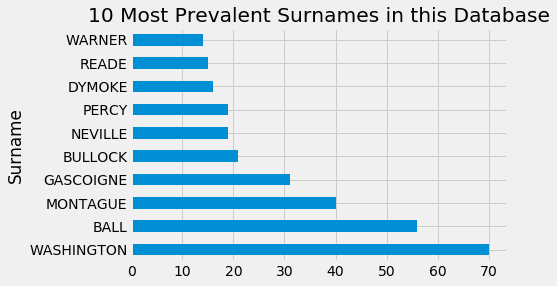

In [95]:
df_surnames = %read_sql SELECT OwnerID, Surname COLLATE NOCASE AS Surname FROM NameTable
df_surnames.groupby('Surname').size().nlargest(10).plot.barh(title='10 Most Prevalent Surnames in this Database')

Let's do a little bit of analysis on how long people lived in this family tree.  To keep things simple, I'll just calculate on the birth year and death year of each individual instead of the individual's actual birth date and death date.  I may be plus or minus a year on certain people, but this will give me a decent rough estimate.

In [96]:
%%read_sql df_ages -d
SELECT OwnerID
    ,Surname COLLATE NOCASE AS Surname
    ,Given COLLATE NOCASE AS Given
    ,BirthYear AS BirthYear
    ,DeathYear AS DeathYear
    ,(DeathYear - BirthYear) AS age
FROM NameTable n
WHERE COALESCE(BirthYear, 0) > 0 AND COALESCE(DeathYear, 0) > 0
    AND (age BETWEEN 0 AND 110) --remove anyone over 110 years of age or under 0 as that's a likely error

Query started at 06:09:29 PM Eastern Daylight Time; Query executed in 0.00 m

In [97]:
oldest = df_ages.sort_values('age', ascending=False).head(1)
youngest = df_ages.sort_values('age').head(1)
print('This family tree contains {0} individuals with recorded birth and death dates.'.format(df_ages.shape[0]))
print('The oldest person in the tree is {0} {1} at age {2}.'.format(oldest.Given.values[0], oldest.Surname.values[0], 
                                                                   oldest.age.values[0]))
print('The youngest person in the tree is {0} {1} at age {2}.'.format(youngest.Given.values[0], youngest.Surname.values[0], 
                                                                      youngest.age.values[0]))
print('The average age for family members in this tree is {0:.1f} years.'.format(df_ages.age.mean()))
print('The median age for family members in this tree is {0:.1f} years.'.format(df_ages.age.median()))

This family tree contains 192 individuals with recorded birth and death dates.
The oldest person in the tree is John WASHINGTON at age 99.
The youngest person in the tree is Mildred WASHINGTON at age 1.
The average age for family members in this tree is 52.9 years.
The median age for family members in this tree is 52.0 years.


Let's scatter plot the ages to see if there's anything interesting there.

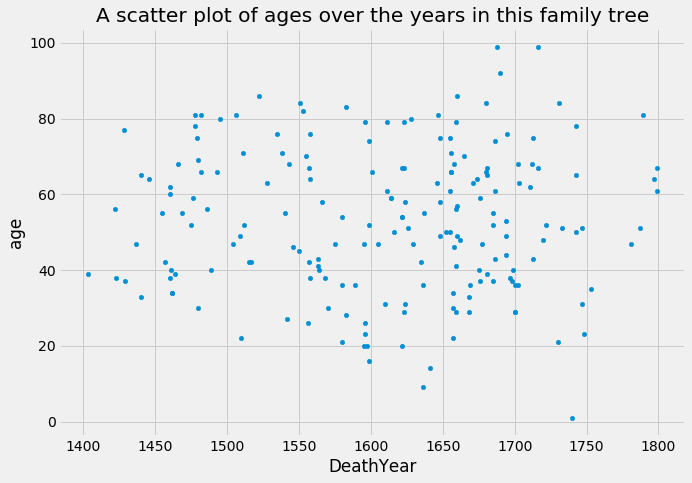

In [98]:
title = 'A scatter plot of ages over the years in this family tree'
df_ages.plot.scatter(x='DeathYear', y='age', figsize=(10, 7), title=title)

# not sure this is the right way to do a trend line, so i'll comment it out for now
# x = df_ages.DeathYear
# y = df_ages.age
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"r--")

# plt.show()

In [99]:
%%read_sql df_family_sizes -d
SELECT FamilyID
    ,COUNT(*) AS family_size
FROM ChildTable
GROUP BY FamilyID

Query started at 06:09:30 PM Eastern Daylight Time; Query executed in 0.00 m

How about checking out the distribution of family sizes?

[Text(0,0.5,'Number of Families in Bin'),
 Text(0.5,0,'Number of Children per Family')]

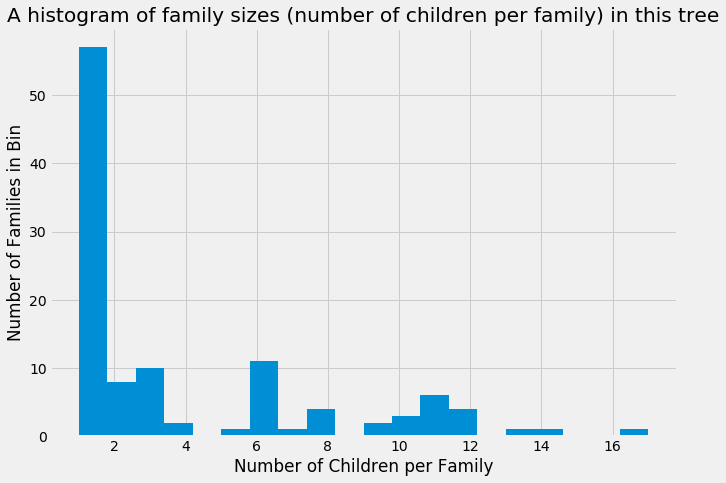

In [100]:
title = 'A histogram of family sizes (number of children per family) in this tree'
ax = df_family_sizes.family_size.plot.hist(bins=20, figsize=(10, 7), title=title)
ax.set(xlabel="Number of Children per Family", ylabel="Number of Families in Bin")

Over half the families in this database only list one child; however, that's probably because the researcher only worked to document a single line and didn't spend time adding in brothers and sisters.

In [101]:
# when we're done looking at the database, let's be a good steward and close our connection
cur.close()
conn.close()